In [93]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [94]:
grunge = pd.read_csv('grunge.csv')

# Adding Popularity Metric From Spotify 

In [95]:
client_id = 'c3c6cbaa304c4c86b120e8d9603d44a4'
client_secret = 'b8819ea70b3142819602499ee139c24f'

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
  client_id=client_id,
  client_secret=client_secret
))

def get_track_popularity(track_name, track_album):
  query = f'track:{track_name} album:{track_album}'
  results = sp.search(q=query, type='track', limit=1)
  if results['tracks']['items']:
    return results['tracks']['items'][0]['popularity']
  return None

In [96]:

grunge['popularity'] = grunge.apply(lambda row: get_track_popularity(row['track_name'], row['album_name']), axis=1)

In [97]:
grunge['is_popular'] = (grunge['popularity'] >= grunge['popularity'].quantile(0.75)).astype(int)

In [98]:
grunge['on_chart'] = grunge.iloc[:,33:97].replace(np.nan, '').astype(str).apply(''.join, axis=1).str.strip()
grunge['on_chart'] = [1  if x != '' else 0 for x in grunge['on_chart']]

In [99]:
grunge = grunge.drop(grunge.columns[list(range(33,97))], axis=1)

In [100]:
popular_given_chart = grunge.loc[grunge['on_chart'] == 1, 'is_popular'].mean()
chart_given_popular = grunge.loc[grunge['is_popular'] == 1, 'on_chart'].mean()

print(f'P(popular | charting): {popular_given_chart*100:.2f}%')
print(f'P(charting | popular): {chart_given_popular*100:.2f}%')

P(popular | charting): 68.25%
P(charting | popular): 24.29%


# Hit Song Forecasting

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance



### Compare Logistic Regression ceofficients

In [111]:
# feature selection
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
            'speechiness', 'tempo', 'valence' , 'duration', 'release_year', 'album_rating']
X = grunge[features]
X['album_rating'].fillna(grunge['album_rating'].mean(), inplace=True)

# two targets
y_chart = grunge['on_chart']
y_popular = grunge['is_popular']

# train-test split
X_train, X_test, y_chart_train, y_chart_test, y_popular_train, y_popular_test = train_test_split(
    X, y_chart, y_popular, test_size=0.2, random_state=42)

# standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train two models
logreg_chart = LogisticRegression(class_weight='balanced', random_state=23).fit(X_train_scaled, y_chart_train)
logreg_popular = LogisticRegression(class_weight='balanced', random_state=23).fit(X_train_scaled, y_popular_train)

# permutation importance
imp_chart = permutation_importance(logreg_chart, X_test_scaled, y_chart_test, n_repeats=20, random_state=42)
imp_popular = permutation_importance(logreg_popular, X_test_scaled, y_popular_test, n_repeats=20, random_state=42)

fi_chart = pd.DataFrame({'feature': X.columns, 'importance_chart': imp_chart.importances_mean})
fi_popular = pd.DataFrame({'feature': X.columns, 'importance_popular': imp_popular.importances_mean})

fi_compare = fi_chart.merge(fi_popular, on='feature')
fi_compare['diff'] = fi_compare['importance_chart'] - fi_compare['importance_popular']

fi_compare.sort_values('importance_chart', ascending=False, inplace=True)

C:\Users\ANA\AppData\Local\Temp\ipykernel_2144\4170291823.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['album_rating'].fillna(grunge['album_rating'].mean(), inplace=True)


C:\Users\ANA\AppData\Local\Temp\ipykernel_2144\520807267.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([i.get_text().title() for i in ax.get_yticklabels()], fontsize=15)


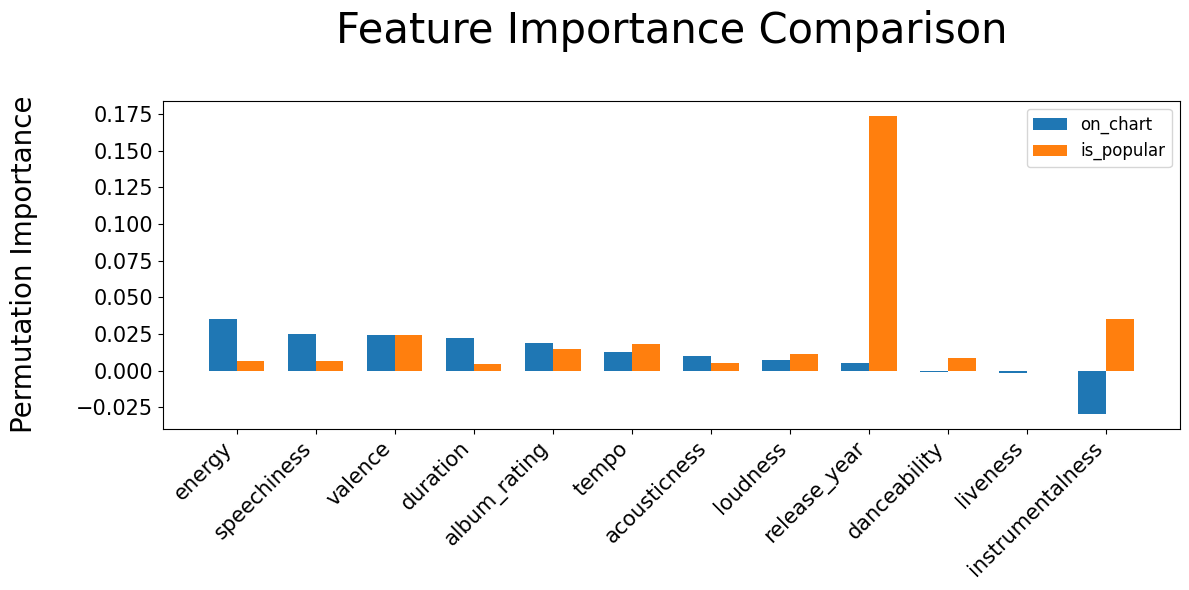

In [116]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(12,6))
width = 0.35
x = range(len(fi_compare))

ax.bar([p - width/2 for p in x], fi_compare['importance_chart'], width=width, label='on_chart')
ax.bar([p + width/2 for p in x], fi_compare['importance_popular'], width=width, label='is_popular')

ax.set_xticks(x)
ax.set_xticklabels(fi_compare['feature'], rotation=45, ha='right', fontsize=15)
ax.set_yticklabels([i.get_text().title() for i in ax.get_yticklabels()], fontsize=15)

ax.set_ylabel('Permutation Importance\n', fontsize=20)
ax.legend(fontsize=12)
plt.title('Feature Importance Comparison\n', fontsize=30)
plt.tight_layout()


plt.savefig('Feature Importance Comparison.png', dpi=600, bbox_inches='tight')
plt.savefig('Feature Importance Comparison.svg', dpi=600, bbox_inches='tight')
plt.savefig('Feature Importance Comparison.pdf', dpi=600, bbox_inches='tight')

plt.show()

In [113]:

fi_compare['rank_chart'] = fi_compare['importance_chart'].rank(ascending=False)
fi_compare['rank_popular'] = fi_compare['importance_popular'].rank(ascending=False)
fi_compare['rank_diff'] = fi_compare['rank_chart'] - fi_compare['rank_popular']

fi_compare.sort_values('rank_diff', ascending=True).head(10)

,feature,importance_chart,importance_popular,diff,rank_chart,rank_popular,rank_diff
2,energy,0.035211,0.006690,0.028521,1.0,8.5,-7.5
9,duration,0.022183,0.004577,0.017606,4.0,11.0,-7.0
6,speechiness,0.025352,0.006690,0.018662,2.0,8.5,-6.5
0,acousticness,0.010211,0.005282,0.004930,7.0,10.0,-3.0
4,liveness,-0.001761,0.000000,-0.001761,11.0,12.0,-1.0
8,valence,0.024648,0.024296,0.000352,3.0,3.0,0.0
11,album_rating,0.019014,0.015141,0.003873,5.0,5.0,0.0
7,tempo,0.012676,0.017958,-0.005282,6.0,4.0,2.0
5,loudness,0.007394,0.011620,-0.004225,8.0,6.0,2.0
1,danceability,-0.000704,0.008803,-0.009507,10.0,7.0,3.0
